In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from functools import reduce

In [2]:
mpl.rcParams['figure.figsize'] = (9, 5)

# Goal
My goal is to visualize various aspect of the `COVID-19` pandemic.

# Data sources

In this project I use data from the following sources:
- https://github.com/CSSEGISandData/COVID-19 - JHU CSSE COVID-19 Data.
- [GDP per capita PPP](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) - The World Bank.
- [Population](https://data.worldbank.org/indicator/SP.POP.TOTL) - The World Bank.
- [Urban Population](https://data.worldbank.org/indicator/SP.URB.TOTL.IN.ZS) - The World Bank.
- [Population living in slums](https://data.worldbank.org/indicator/EN.POP.SLUM.UR.ZS) - The World Bank.
- [Rural population](https://data.worldbank.org/indicator/SP.RUR.TOTL.ZS) - The World Bank.
- [Life expectancy at birth](https://data.worldbank.org/indicator/SP.DYN.LE00.IN) - The World Bank.
- [Current healthcare expenditure](https://data.worldbank.org/indicator/SH.XPD.CHEX.GD.ZS) - The World Bank.
- https://datahub.io/JohnSnowLabs/country-and-continent-codes-list - country codes and continents.

# Data preparation

## COVID-19 data
To  obtain a copy of the data clone the repository: <br>
`git clone https://github.com/CSSEGISandData/COVID-19`

In [3]:
path = './data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'

In [4]:
conf = pd.read_csv(f'{path}/time_series_covid19_confirmed_global.csv')
recov = pd.read_csv(f'{path}/time_series_covid19_recovered_global.csv')
dead = pd.read_csv(f'{path}/time_series_covid19_deaths_global.csv')

In [5]:
def rename_countries(df):
    
    # Fix country names.
    # This also helps with grouping (eg. Congo)
    df['Country'] = df['Country'].apply(lambda x: "Taiwan" if x == "Taiwan*" else x)
    df['Country'] = df['Country'].apply(lambda x: "Korea" if x == "Korea, South" else x)
    df['Country'] = df['Country'].apply(lambda x: "Macedonia"  if x == "North Macedonia" else x)
    df['Country'] = df['Country'].apply(lambda x: "Cape Verde" if x == "Cabo Verde" else x)
    df['Country'] = df['Country'].apply(lambda x: "Congo" if x == "Congo (Brazzaville)"  else x)
    df['Country'] = df['Country'].apply(lambda x: "Congo" if x == "Congo (Kinshasa)" else x)
    
    return df

In [6]:
def process_data(df):
    """
    
    Convert data from columns to rows.
    
    """
    
    # Drop columns
    df = df.drop(['Lat', 'Long', 'Province/State'], axis=1)
    df = df.rename(columns={"Country/Region": "Country"})    
    
    # Rename countries
    df = rename_countries(df=df)
    
    # Enforce countries are unique
    df = df.groupby('Country', as_index=False).sum()        
    
    # Switch to colum format
    df = df.transpose()
    
    # Copy headers from first row
    df.columns = df.iloc[0, :].to_list()
    df['Date'] = df.index
    df = df[1:]    
    
    # Convert dates
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Convert to ints
    cols = df.columns.to_list()
    cols.remove('Date')
    for col in cols:
        df[col] = df[col].astype(int)
    
    # Reorder & Sort    
    cols = ['Date'] + sorted(cols)
    df = df[cols]
    
    # Reset index
    df = df.reset_index(drop=True)
    df.head()    
    
    return df

In [7]:
conf = process_data(df=conf)
recov = process_data(df=recov)
dead = process_data(df=dead)
conf.tail()

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
225,2020-09-03,38288,9844,45469,1199,2805,95,451198,44271,26136,...,342708,1636,42688,49877,1046,24471,10,1979,12523,6678
226,2020-09-04,38304,9967,45773,1215,2876,95,461882,44461,26207,...,344686,1653,42998,50973,1049,25142,10,1983,12639,6837
227,2020-09-05,38324,10102,46071,1215,2935,95,471806,44649,26278,...,346513,1669,43293,52165,1049,25575,10,1983,12709,6837
228,2020-09-06,38398,10255,46364,1215,2965,95,478792,44783,26321,...,349500,1679,43587,53289,1049,26127,10,1987,12776,6837
229,2020-09-07,38494,10406,46653,1261,2981,95,488007,44845,26373,...,352451,1693,43893,54350,1049,26779,10,1989,12836,7298


In [8]:
boats = ['Diamond Princess', 'MS Zaandam']
conf = conf.drop(boats, axis=1)
recov = recov.drop(boats, axis=1)
dead = dead.drop(boats, axis=1)

active = conf.drop(['Date'], axis=1) - recov.drop(['Date'], axis=1) - dead.drop(['Date'], axis=1)
active['Date'] = conf['Date']

## Helper functions

In [9]:
dataframes = [conf, recov, dead]
names = ['Confirmed', 'Recovered', 'Deaths']

In [10]:
def get_country_ts(country, dataframes, columns):
    """
    
    Extract data for specific country.
    
    Notes
    -----
    Apply backfill to NaN's.
    
    """
    
    cols = ['Date'] + columns
    ctry = list()
    for df in dataframes:
        tmp = df.loc[:, ['Date', country]]
        ctry.append(tmp)        
    ctry = reduce(lambda x, y: pd.merge(x, y, on='Date', how='outer'), ctry)    
    ctry.columns = cols
    ctry = ctry.fillna(method='bfill')
    
    return ctry

get_country_ts(country='Poland', 
               dataframes=dataframes, 
               columns=names).tail()

,Date,Confirmed,Recovered,Deaths
225,2020-09-03,69129,48593,2092
226,2020-09-04,69820,49820,2100
227,2020-09-05,70387,52346,2113
228,2020-09-06,70824,54256,2120
229,2020-09-07,71126,55113,2124


In [11]:
def get_country_stats(dataframes, names):
    """
    
    Create dataframe with cases summarize
    by country.
    
    """
    
    stats = []
    for df,name in zip(dataframes, names):
        tmp = df.tail(1).drop('Date', axis=1)
        tmp = tmp.transpose()
        tmp = tmp.reset_index()
        tmp.columns = ['Country', name]
        stats.append(tmp)
    stats = reduce(lambda x, y: pd.merge(x, y, on='Country', how='outer'), stats)    
    
    return stats

get_country_stats(dataframes, names).head()

,Country,Confirmed,Recovered,Deaths
0,Afghanistan,38494,30557,1415
1,Albania,10406,6186,319
2,Algeria,46653,32985,1562
3,Andorra,1261,934,53
4,Angola,2981,1215,120


## Extract mortality rate

In [12]:
def extract_mortality(country):
    """
    
    Calculate mortality rate over time
    for specific country.
    
    """
    
    df = get_country_ts(country=country, 
                        dataframes=[conf, dead], 
                        columns=['Confirmed', 'Deaths'])
    df = df[df['Confirmed'] > 0]
    df['Mortality'] = df['Deaths'] / df['Confirmed']
    df['Mortality'] = df['Mortality'] * 100
    df['Mortality'] = np.round(df['Mortality'], 2)
    df = df[['Date', 'Mortality']]
    df.columns = ['Date', country]
    
    return df

extract_mortality('Poland').tail()

,Date,Poland
225,2020-09-03,3.03
226,2020-09-04,3.01
227,2020-09-05,3.00
228,2020-09-06,2.99
229,2020-09-07,2.99


In [13]:
all_countries = sorted(set(conf.drop('Date', axis=1).columns))
mort = list()
for c in all_countries:
    tmp = extract_mortality(country=c)
    mort.append(tmp)
    
mort = reduce(lambda x, y: pd.merge(x, y, on='Date'), mort)    

mort.tail()

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
113,2020-09-03,3.68,3.06,3.36,4.42,4.03,3.16,2.07,2.00,2.82,...,12.14,2.69,0.78,0.81,3.35,0.68,10.0,28.85,2.33,3.08
114,2020-09-04,3.68,3.07,3.36,4.36,4.00,3.16,2.08,2.00,2.85,...,12.08,2.72,0.79,0.81,3.34,0.68,10.0,28.85,2.31,3.01
115,2020-09-05,3.68,3.09,3.36,4.36,3.99,3.16,2.06,2.00,2.87,...,12.02,2.70,0.79,0.81,3.34,0.69,10.0,28.85,2.30,3.01
116,2020-09-06,3.68,3.08,3.36,4.36,3.95,3.16,2.06,2.00,2.90,...,11.91,2.68,0.80,0.80,3.34,0.69,10.0,28.79,2.31,3.01
117,2020-09-07,3.68,3.07,3.35,4.20,4.03,3.16,2.08,2.01,2.92,...,11.82,2.66,0.80,0.80,3.34,0.69,10.0,28.81,2.30,2.88


In [14]:
print(conf.shape)
print(recov.shape)
print(dead.shape)
print(active.shape)
print(mort.shape)

(230, 186)
(230, 186)
(230, 186)
(230, 186)
(118, 186)


In [15]:
def count_na(df):
    df = df.drop('Date', axis=1).isna().sum(axis=0)
    df.name = 'Missing'
    df = df.to_frame()
    df.sort_values('Missing', ascending=False)
    return df

In [16]:
count_na(conf).head()

,Missing
Afghanistan,0
Albania,0
Algeria,0
Andorra,0
Angola,0


In [17]:
count_na(recov).head()

,Missing
Afghanistan,0
Albania,0
Algeria,0
Andorra,0
Angola,0


In [18]:
count_na(dead).head()

,Missing
Afghanistan,0
Albania,0
Algeria,0
Andorra,0
Angola,0


In [19]:
count_na(active).head()

,Missing
Afghanistan,0
Albania,0
Algeria,0
Andorra,0
Angola,0


In [20]:
count_na(mort).head()

,Missing
Afghanistan,0
Albania,0
Algeria,0
Andorra,0
Angola,0


In [21]:
dataframes = [conf, recov, dead, active, mort]
names = ['Confirmed', 'Recovered', 'Deaths', 'Active', 'Mortality']
country_stats = get_country_stats(dataframes, names)
country_stats.head()

,Country,Confirmed,Recovered,Deaths,Active,Mortality
0,Afghanistan,38494,30557,1415,6522,3.68
1,Albania,10406,6186,319,3901,3.07
2,Algeria,46653,32985,1562,12106,3.35
3,Andorra,1261,934,53,274,4.20
4,Angola,2981,1215,120,1646,4.03


In [22]:
country_stats.isna().sum(axis=0)

Country      0
Confirmed    0
Recovered    0
Deaths       0
Active       0
Mortality    0
dtype: int64

## First order differences

In [23]:
def get_daily_changes(df):   
    """
    
    Calculate daily change in case
    data, ie apply difference operator.
    
    """
    diff = df.drop(['Date'], axis=1) - df.drop(['Date'], axis=1).shift(1)
    diff['Date'] = df['Date']
    diff.dropna(inplace=True)
    diff.tail()
    return diff

In [24]:
conf_diff = get_daily_changes(df=conf)
recov_diff = get_daily_changes(df=recov)
dead_diff = get_daily_changes(df=dead)
active_diff = get_daily_changes(df=active)
conf_diff.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe,Date
225,45.0,116.0,311.0,0.0,28.0,1.0,12026.0,196.0,87.0,403.0,...,10.0,251.0,994.0,0.0,596.0,0.0,3.0,108.0,40.0,2020-09-03
226,16.0,123.0,304.0,16.0,71.0,0.0,10684.0,190.0,71.0,357.0,...,17.0,310.0,1096.0,3.0,671.0,0.0,4.0,116.0,159.0,2020-09-04
227,20.0,135.0,298.0,0.0,59.0,0.0,9924.0,188.0,71.0,358.0,...,16.0,295.0,1192.0,0.0,433.0,0.0,0.0,70.0,0.0,2020-09-05
228,74.0,153.0,293.0,0.0,30.0,0.0,6986.0,134.0,43.0,184.0,...,10.0,294.0,1124.0,0.0,552.0,0.0,4.0,67.0,0.0,2020-09-06
229,96.0,151.0,289.0,46.0,16.0,0.0,9215.0,62.0,52.0,290.0,...,14.0,306.0,1061.0,0.0,652.0,0.0,2.0,60.0,461.0,2020-09-07


## Coordinate data

In [25]:
coords = pd.read_csv(f'{path}/time_series_covid19_confirmed_global.csv')
coords = coords.rename(columns={"Country/Region": "Country"})   
coords = coords.loc[~coords['Country'].isin(boats)]
coords = rename_countries(df=coords)
coords = coords[['Country', 'Lat', 'Long']]
coords = coords.groupby('Country', as_index=False).mean()
coords = coords.sort_values('Country')
coords = coords.reset_index(drop=True)
coords.head()

,Country,Lat,Long
0,Afghanistan,33.93911,67.709953
1,Albania,41.15330,20.168300
2,Algeria,28.03390,1.659600
3,Andorra,42.50630,1.521800
4,Angola,-11.20270,17.873900


## Continent data

In [26]:
cont_path = './data/datahub/countries.csv'
cont_map = pd.read_csv(cont_path)

cont_map = cont_map.drop(['Continent_Code', 
                          'Two_Letter_Country_Code', 
                          'Country_Number'], axis=1)

cont_map['Country'] = cont_map['Country_Name'].apply(lambda x: x.split(", ")[0])
cont_map = cont_map.rename(columns={"Continent_Name": "Continent", 'Three_Letter_Country_Code': 'Country Code'})
cont_map = cont_map.drop(['Country_Name'], axis=1)
cont_map = cont_map.drop_duplicates(subset=['Country'])

cont_map.head()

,Continent,Country Code,Country
0,Asia,AFG,Afghanistan
1,Europe,ALB,Albania
2,Antarctica,ATA,Antarctica (the territory South of 60 deg S)
3,Africa,DZA,Algeria
4,Oceania,ASM,American Samoa


In [27]:
countries_covid = set(coords['Country'])

In [28]:
# Change values in countries.csv to match covid data.
to_swap = [('Russian Federation', 'Russia'),
           ('Slovakia (Slovak Republic)', 'Slovakia'),
           ('Kyrgyz Republic', 'Kyrgyzstan'),
           ('Syrian Arab Republic', 'Syria'),
           ('Libyan Arab Jamahiriya', 'Libya'),
           ('Korea, South', 'Korea'),
           ('Brunei Darussalam', 'Brunei'),
           ('Cabo Verde', 'Cape Verde'),
           ('Holy See (Vatican City State)', 'Holy See'),
           ('United States of America', 'US'),
           ('United Kingdom of Great Britain & Northern Ireland', 'United Kingdom'),
           ("Lao People's Democratic Republic", 'Laos'),
           ('Myanmar', 'Burma'),
           ('Czech Republic', 'Czechia'),
           ('Swaziland',  'Eswatini')]

for x in to_swap:
    cont_map.loc[cont_map['Country'] == x[0], 'Country'] = x[1]    

In [29]:
countries_cont_map = set(cont_map['Country'])

In [30]:
countries_covid.difference(countries_cont_map)

{'Kosovo', 'West Bank and Gaza'}

In [31]:
ctry_to_cont = pd.merge(coords, cont_map, how='left', on='Country')
ctry_to_cont = ctry_to_cont.dropna()
ctry_to_cont.head()

,Country,Lat,Long,Continent,Country Code
0,Afghanistan,33.93911,67.709953,Asia,AFG
1,Albania,41.15330,20.168300,Europe,ALB
2,Algeria,28.03390,1.659600,Africa,DZA
3,Andorra,42.50630,1.521800,Europe,AND
4,Angola,-11.20270,17.873900,Africa,AGO


In [32]:
print(ctry_to_cont.shape)

(183, 5)


## World Bank data

In [33]:
wb_path = './data/world_bank/'

In [34]:
def get_world_bank_data(path, desc):
    """
    
    Get World Bank data into usable format.
    
    Notes
    -----
    Forward filling is applied rowwise.
    
    """
    
    df = pd.read_csv(path, skiprows=4)
    df = df.rename(columns={'Country Name': 'Country'})
    df = df.drop(['Country', 'Indicator Name', 'Indicator Code'], axis=1)    
    df = df.ffill(axis=1)
    df = df[['Country Code', '2019']]
    df = df.rename(columns={'2019': desc})
    df = df[~(df[desc].str.isalpha() == True)]
    df[desc] = df[desc].astype(float)
    df[desc] = df[desc].round(2)
    
    return df

In [35]:
wb_le = 'API_SP.DYN.LE00.IN_DS2_en_csv_v2_1308162.csv'
life_expectancy = get_world_bank_data(path=f'{wb_path}/{wb_le}',
                                      desc='Life Expectancy')
life_expectancy.head()

,Country Code,Life Expectancy
0,ABW,76.15
1,AFG,64.49
2,AGO,60.78
3,ALB,78.46
5,ARB,71.81


In [36]:
wb_gdp = 'API_NY.GDP.PCAP.PP.CD_DS2_en_csv_v2_1217517.csv'
gdp_per_capita = get_world_bank_data(path=f'{wb_path}/{wb_gdp}',
                                     desc='GDP Per Capita')
gdp_per_capita.head()

,Country Code,GDP Per Capita
0,ABW,38442.41
1,AFG,2293.55
2,AGO,6929.68
3,ALB,14495.08
5,ARB,15216.54


In [37]:
wb_pop = 'API_SP.POP.TOTL_DS2_en_csv_v2_1308146.csv'
population = get_world_bank_data(path=f'{wb_path}/{wb_pop}',
                                     desc='Population')
population.head()

,Country Code,Population
0,ABW,106314.0
1,AFG,38041754.0
2,AGO,31825295.0
3,ALB,2854191.0
4,AND,77142.0


In [38]:
wb_urb = 'API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_1219669.csv'
urban_population = get_world_bank_data(path=f'{wb_path}/{wb_urb}',
                                     desc='Urban Population %')
urban_population.head()

,Country Code,Urban Population %
0,ABW,43.55
1,AFG,25.75
2,AGO,66.18
3,ALB,61.23
4,AND,87.98


In [39]:
wb_slum = 'API_EN.POP.SLUM.UR.ZS_DS2_en_csv_v2_1221614.csv'
slum_population = get_world_bank_data(path=f'{wb_path}/{wb_slum}',
                                     desc='Slum Population %')
slum_population.head()

,Country Code,Slum Population %
1,AFG,62.70
2,AGO,55.50
5,ARB,32.52
7,ARG,16.70
8,ARM,14.40


In [40]:
wb_rur = 'API_SP.RUR.TOTL.ZS_DS2_en_csv_v2_1222914.csv'
rural_population = get_world_bank_data(path=f'{wb_path}/{wb_rur}',
                                     desc='Rural Population %')
rural_population.head()

,Country Code,Rural Population %
0,ABW,56.45
1,AFG,74.25
2,AGO,33.82
3,ALB,38.77
4,AND,12.02


In [41]:
wb_hc = 'API_SH.XPD.CHEX.GD.ZS_DS2_en_csv_v2_1217782.csv'
gdp_healthcare = get_world_bank_data(path=f'{wb_path}/{wb_hc}',
                                     desc='GDP Healthcare %')
gdp_healthcare.head()

,Country Code,GDP Healthcare %
1,AFG,11.78
2,AGO,2.79
4,AND,10.32
5,ARB,4.86
6,ARE,3.33


In [42]:
world_bank = [life_expectancy,
              gdp_per_capita,
              population,
              urban_population,
              slum_population,
              rural_population,
              gdp_healthcare]

world_bank = reduce(lambda x, y: pd.merge(x, y, on='Country Code', how='outer'), world_bank)
world_bank.head()

,Country Code,Life Expectancy,GDP Per Capita,Population,Urban Population %,Slum Population %,Rural Population %,GDP Healthcare %
0,ABW,76.15,38442.41,106314.0,43.55,NaN,56.45,NaN
1,AFG,64.49,2293.55,38041754.0,25.75,62.70,74.25,11.78
2,AGO,60.78,6929.68,31825295.0,66.18,55.50,33.82,2.79
3,ALB,78.46,14495.08,2854191.0,61.23,NaN,38.77,NaN
4,ARB,71.81,15216.54,427870270.0,59.20,32.52,40.80,4.86


In [43]:
world_bank.shape

(263, 8)

In [44]:
wb_missing = world_bank.isnull().sum(axis=0)
wb_missing.name = 'Missing'
wb_missing = wb_missing.to_frame()
wb_missing = wb_missing.sort_values('Missing', ascending=False)
wb_missing = wb_missing.reset_index()
wb_missing = wb_missing.rename(columns={'index': 'Column'})
wb_missing = wb_missing[wb_missing['Missing'] > 0]
wb_missing

,Column,Missing
0,Slum Population %,124
1,GDP Healthcare %,29
2,GDP Per Capita,20
3,Life Expectancy,9
4,Urban Population %,2
5,Rural Population %,2


## Merge world bank with COVID-19

In [45]:
# Check missing countries
S1 = set(ctry_to_cont['Country Code'])
S2 = set(world_bank['Country Code'])
sorted(S1.difference(S2))

['ESH', 'TWN', 'VAT']

In [46]:
ctry_to_cont[ctry_to_cont['Country Code'] == 'ESH']

,Country,Lat,Long,Continent,Country Code
181,Western Sahara,24.2155,-12.8858,Africa,ESH


In [47]:
ctry_to_cont[ctry_to_cont['Country Code'] == 'TWN']

,Country,Lat,Long,Continent,Country Code
162,Taiwan,23.7,121.0,Asia,TWN


In [48]:
ctry_to_cont[ctry_to_cont['Country Code'] == 'VAT']

,Country,Lat,Long,Continent,Country Code
73,Holy See,41.9029,12.4534,Europe,VAT


In [49]:
merged = pd.merge(ctry_to_cont, country_stats, on='Country', how='outer')
merged = pd.merge(merged, world_bank, on='Country Code', how='outer')
merged.shape

(268, 17)

# Data - summary

After the lengthy process of preparing the data I feel obliged to summarize in short some of the key datasets.

From the original `COVID-19` data we created:
- `conf` - Confirmed cases. Timeseries, by country.
- `recov` - Recovered cases. Timeseries, by country.
- `dead` - Fatal cases. Timeseries, by country.
- `active` - Active cases. Calculation: `conf` - `recov` - `dead`. Timeseries, by country.
- `coords` - Countries with latitude and longitude data.
- `country_stats` - Case data summarized by country.

By transforming the above we obtain:
- `conf_diff` - Confirmed cases daily change. Calculated using the difference operator. Timeseries, by country.
- `active_diff` - Confirmed cases daily change. Calculated using the difference operator. Timeseries, by country.
- `recov_diff` - Recovered cases daily change. Calculated using the difference operator. Timeseries, by country.
- `dead_diff` - Fatal cases daily change. Calculated using the difference operator. Timeseries, by country.
- `mort` - Mortality, expressed by `dead`/`conf`. Timeseries, by country.

From X we create:
- `ctry_to_cont` - Map each country to continent.

Using the data above and data from the World Bank we create:
- `world_bank` - Combines all the data from the World Bank.
- `merged` - Combines COVID-19 summary statistics, continents, gdp and population data.

The `COVID-19` data used in this notebook starts on:

In [50]:
str(conf['Date'].min().date())

'2020-01-22'

and ends on:

In [51]:
str(conf['Date'].max().date())

'2020-09-07'

# COVID19 - Globally

First we plot the total number of cases around the world.

In [52]:
all_countries = sorted(set(coords['Country']))
dataframes = [conf, recov, dead, active]
names = ['Confirmed cases',
         'Recovered cases',
         'Fatal cases',
         'Active cases']

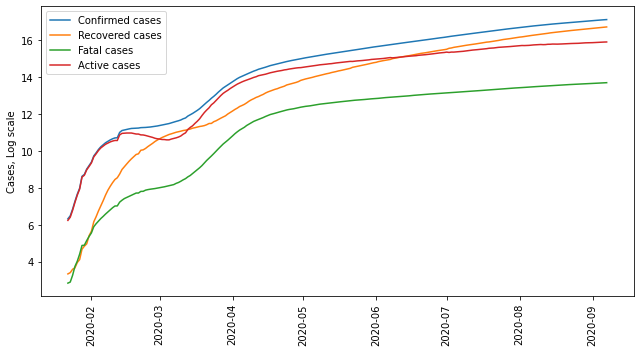

In [53]:
for name,df in zip(names, dataframes):
    plt.plot(df['Date'],
             np.log(df.drop('Date', axis=1).sum(axis=1)),
             label=name)
plt.ylabel('Cases, Log scale')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# COVID19 - By continent

We drill down further into the data visualizing cases data at the continent level.

In [54]:
def continent_plot(df, name):
    """
    
    Plot cases over time by continent.
    
    """
    
    continents = set(ctry_to_cont['Continent'])
    for cont in continents:

        C = ctry_to_cont[ctry_to_cont['Continent'] == cont]
        C = C['Country'].to_list()

        plt.plot(df['Date'], df[C].sum(axis=1), label=cont)

    plt.legend(loc='best')
    plt.title(f'{name}')
    plt.ylabel('Cases, log scale')
    plt.tight_layout()
    plt.show()    

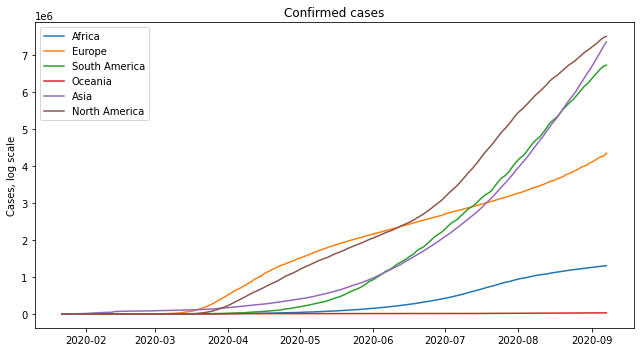

In [55]:
for name,df in zip(names, dataframes):
    continent_plot(df=df, name=name)  
    break

# COVID - Country level

Finally we can take a look at the data on a country level. First we show the countries with the most cases.

In [56]:
def sorted_bar_plot(df, name, n=10):
    """
    
    Bar plot of countries with the most cases
    of a certain type.
    
    """
        
    df = df.sum()
    df.name = name
    df = df.to_frame()
    df = df.sort_values(name, ascending=False)
    df = df.reset_index()
    df = df.rename(columns={'index': 'Country'})
    df = df.head(n)

    plt.bar(df['Country'], df[name])
    plt.xticks(rotation=90)
    plt.title(f'{name}')
    plt.ylabel('Cases, log scale')
    plt.tight_layout()
    plt.show()    

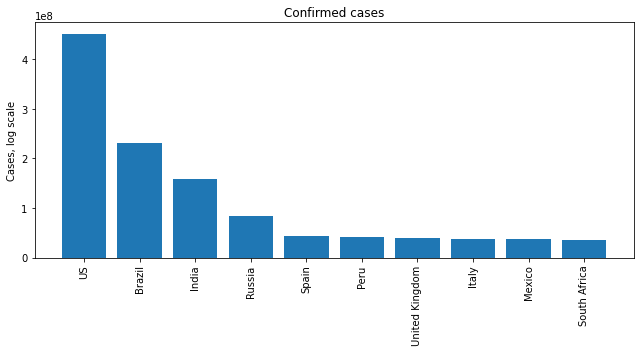

In [57]:
for name,df in zip(names, dataframes):
    sorted_bar_plot(df=df, name=name) 
    break

Then we show countries with the highest mortality rate.

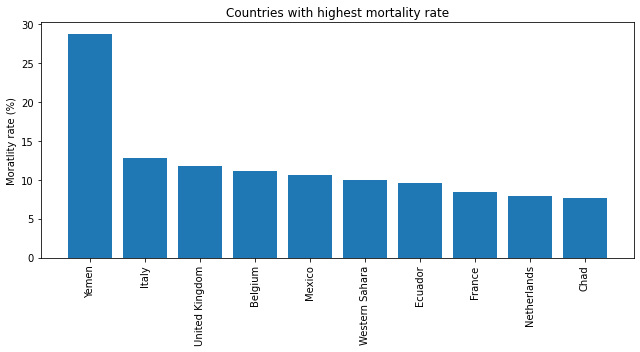

In [58]:
high_mort = country_stats[['Country', 'Mortality']]
high_mort = high_mort.sort_values('Mortality', ascending=False)
high_mort = high_mort.reset_index(drop=True)
high_mort.columns = ['Country', 'Mortality Rate']
high_mort = high_mort.head(10)

plt.bar(high_mort['Country'], height=high_mort['Mortality Rate'])
plt.xticks(rotation=90)
plt.ylabel('Moratlity rate (%)')
plt.title('Countries with highest mortality rate')
plt.tight_layout()
plt.show()

In [59]:
def country_plot_cases(country):
    """
    
    Plot country level cases data.
    
    """
    
    names = ['Confirmed', 'Recovered', 'Fatal', 'Active']
    dataframes= [conf, recov, dead, active]    
    
    df = get_country_ts(country=country,
                        dataframes=dataframes,
                        columns=names)
    
    df = df[df['Confirmed'] > 0]
    
    plt.plot(df['Date'], df['Confirmed'], label=names[0])
    plt.plot(df['Date'], df['Recovered'], label=names[1])
    plt.plot(df['Date'], df['Fatal'], label=names[2])
    plt.plot(df['Date'], df['Active'], label=names[3])    
    
    plt.title(f'{country}')
    plt.ylabel('Cases')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()      

We can inspect the data for specific countries.

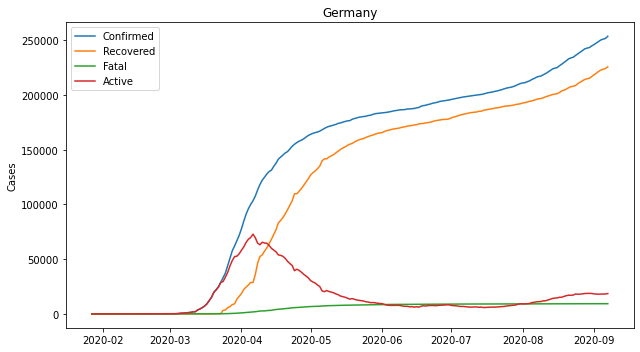

In [60]:
country_plot_cases(country='Germany')

We plot the daily increase in cases for specific countries.

In [61]:
def country_plot_chg(country, n=7):
    """
    
    Plot country level change in cases with
    n day moving average.
    
    """
    names = ['Confirmed Chg']
    dataframes= [conf_diff]        
    
    df = get_country_ts(country=country, dataframes=dataframes, columns=names)
    df = df.rename(columns={'Confirmed Chg': 'New cases'})
    
    plt.plot(df['Date'], df['New cases'],
             label='New cases', alpha=1/2)
    
    plt.fill_between(df['Date'], y1=0, y2=df['New cases'], alpha=1/4)
    
    plt.plot(df['Date'], df['New cases'].rolling(n).mean(), 
             label=f'{n} day average', c='black')    
    
    plt.title(f'{country} - daily new cases')
    plt.ylabel('Cases')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()  

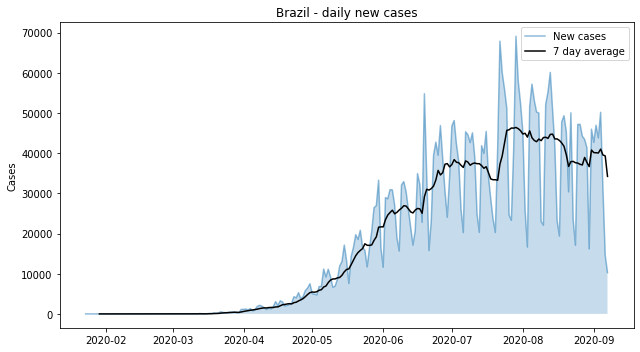

In [62]:
country_plot_chg(country='Brazil')        

# Exponential growth

We proceed to visualize the early days of the pandemic. In most cases the growth was exponential as will be seen.
First we create define a function to calculate exponential growth. Secondly we create dataset of timeseries reindexed to begin at the point in time `t0` defined as the first day where a country reported more than a hundred confirmed cases. Then we plot the data.

In [63]:
def exp_growth(a, b, t, tau):
    """
    
    Calculate exponential growth.
    
    Parameters
    ----------
    a : int
        Initial value.
    b : int
        Growth factor.
    t : int 
        Time.
    tau : int
        Time required for increase by factor of b.
        
    Notes
    -----
    See https://en.wikipedia.org/wiki/Exponential_growth 
    for details.
    
    """
    
    return a * np.power(b, t / tau) 

In [64]:
conf_t0 = list()
for country in all_countries:
    t0 = get_country_ts(country=country, dataframes=[conf], columns=['Confirmed'])
    t0 = t0.loc[t0['Confirmed'] >= 100]
    t0 = t0.loc[:, ['Confirmed']]
    t0 = t0.reset_index(drop=True)
    conf_t0.append(t0)
    
conf_t0 = reduce(lambda x, y: pd.merge(x, y, left_index=True, 
                                       right_index=True, how='outer'), 
                 conf_t0)    
conf_t0.columns = all_countries
conf_t0 = conf_t0.head(100)
max_cases = max(conf_t0.max())

In [65]:
def growth_plot(df, countries, periods, steps=50):
    """
    
    Plot growth curves, log scale.
    
    Inputs
    ------
    df :
        `conf_t0` dataframe that contains confirmed
        cases reindexed to start with the date a 
        country had  >= 100 cases.
    countries : list
        List of countries
    periods : list of ints
        Doubling periods for growth curves.
    steps : int
        Number of data points to use.
    
    """
    
    countries = sorted(countries)
    
    # Extract mean and use as starting point for 
    # exponential growth curves.
    a = df.mean(axis=1)[0]
    b = 2

    # List of growth curves
    growth = list()
    for period in periods:
        g = exp_growth(a=a, 
                       b=b, 
                       t=np.arange(steps), 
                       tau=period)
        g = np.log(g)
        growth.append(list(g))

    for g,p in zip(growth, periods):

        # Draw growth curves
        plt.plot(range(steps), g, 
                 c='black', 
                 linestyle='dashed', 
                 alpha=1/2)

        if p == 1:
            s = f'Double every day'
        else:
            s = f'Double every {str(p)} days'       

        # Draw text outside
        plt.text(x=steps,
                 y=g[steps - 1],
                 s=s, 
                 alpha=3/4, 
                 horizontalalignment='left',
                 verticalalignment='center',
                 rotation_mode='anchor')

    # Draw country level data
    plot_df = conf_t0[countries].head(steps)
    for c in countries:
        plt.plot(range(len(plot_df)), np.log(plot_df[c]), label=c)

    plt.xlim(0, steps-1)
    plt.legend(loc='best')
    plt.ylabel('Confirmed cases, log scale')
    plt.xlabel('Days since 100 cases')
    plt.tight_layout()
    plt.show()

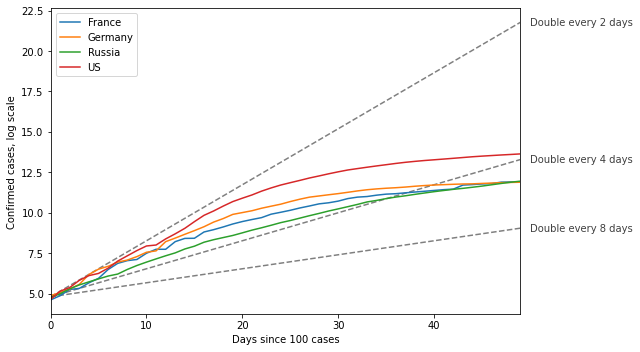

In [66]:
growth_plot(df=conf_t0, 
            countries=['US', 'Russia', 'Germany', 'France'], 
            periods=[2, 4, 8], 
            steps=50)

# Economic data

We proceed to visually inspect the relationship between the `COVID-19` dataset and data downloaded from the World Bank. Given that the `Population` column varies wildy we choose a different metric to make comparisons.

In [67]:
figsize = (5, 5)

In [68]:
economic = merged.copy()

economic['Cases Per Milion'] = economic['Confirmed'] / (economic['Population'] /  10**6)
economic['Cases Per Milion'] = economic['Cases Per Milion'].round(2)

economic['Deaths Per Milion'] = economic['Deaths'] / (economic['Population'] /  10**6)
economic['Deaths Per Milion'] = economic['Deaths Per Milion'].round(2)

economic = economic.drop(['Lat', 'Long', 'Country Code', 'Continent'], axis=1)
economic.head()

,Country,Confirmed,Recovered,Deaths,Active,Mortality,Life Expectancy,GDP Per Capita,Population,Urban Population %,Slum Population %,Rural Population %,GDP Healthcare %,Cases Per Milion,Deaths Per Milion
0,Afghanistan,38494.0,30557.0,1415.0,6522.0,3.68,64.49,2293.55,38041754.0,25.75,62.7,74.25,11.78,1011.89,37.20
1,Albania,10406.0,6186.0,319.0,3901.0,3.07,78.46,14495.08,2854191.0,61.23,NaN,38.77,NaN,3645.87,111.77
2,Algeria,46653.0,32985.0,1562.0,12106.0,3.35,76.69,11820.09,43053054.0,73.19,11.8,26.81,6.37,1083.62,36.28
3,Andorra,1261.0,934.0,53.0,274.0,4.20,NaN,NaN,77142.0,87.98,NaN,12.02,10.32,16346.48,687.04
4,Angola,2981.0,1215.0,120.0,1646.0,4.03,60.78,6929.68,31825295.0,66.18,55.5,33.82,2.79,93.67,3.77


In [69]:
economic.sort_values('Mortality', ascending=False).head()

,Country,Confirmed,Recovered,Deaths,Active,Mortality,Life Expectancy,GDP Per Capita,Population,Urban Population %,Slum Population %,Rural Population %,GDP Healthcare %,Cases Per Milion,Deaths Per Milion
180,Yemen,1989.0,1201.0,573.0,215.0,28.81,66.10,3688.52,29161922.0,37.27,60.8,62.73,4.23,68.21,19.65
83,Italy,278784.0,210238.0,35553.0,32993.0,12.75,83.35,44196.69,60297396.0,70.74,NaN,29.26,8.84,4623.48,589.63
174,United Kingdom,352451.0,1824.0,41643.0,308984.0,11.82,81.26,48709.70,66834405.0,83.65,NaN,16.35,9.63,5273.50,623.08
16,Belgium,88769.0,18576.0,9909.0,60284.0,11.16,81.60,54545.15,11484055.0,98.04,NaN,1.96,10.34,7729.76,862.85
110,Mexico,637509.0,531334.0,67781.0,38394.0,10.63,74.99,20410.71,127575529.0,80.44,11.1,19.56,5.52,4997.11,531.30


## GDP Healthcare
We compare the percentage of gdp spent on healthcare with cases per milion.

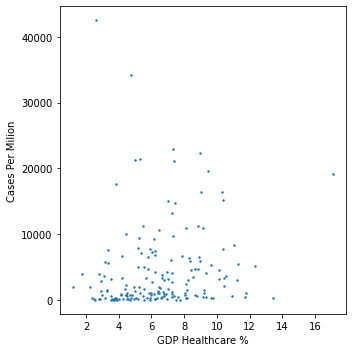

In [70]:
cols = ['Cases Per Milion', 'Deaths Per Milion']

for col in cols:
    plt.figure(figsize=figsize)
    plt.scatter(economic['GDP Healthcare %'], economic[col], s=2)
    plt.xlabel('GDP Healthcare %')
    plt.ylabel(f'{col}')
    plt.tight_layout()
    plt.show()
    break

## Population

We compare the proportion of people living in different areas to the mortality rate.

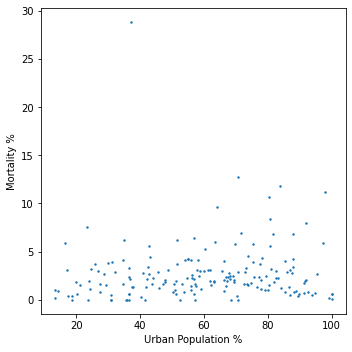

In [71]:
cols = ['Urban Population %', 
        'Rural Population %', 
        'Slum Population %']

for col in cols:
    plt.figure(figsize=figsize)
    plt.scatter(economic[col], economic['Mortality'], s=2)
    plt.ylabel('Mortality %')
    plt.xlabel(f'{col}')
    plt.tight_layout()
    plt.show()
    break    

## GDP & Healthcare
We compare life expectancy, healthcare spending and gdp per capita to the mortality rate.

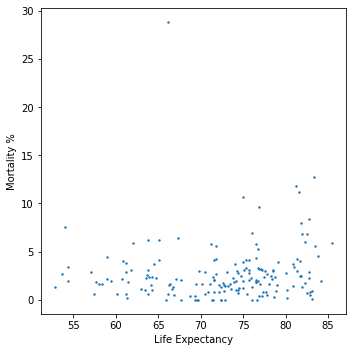

In [72]:
cols = ['Life Expectancy', 'GDP Healthcare %', 'GDP Per Capita']

for col in cols:
    plt.figure(figsize=figsize)
    plt.scatter(economic[col], economic['Mortality'], s=2)
    plt.ylabel('Mortality %')
    plt.xlabel(f'{col}')
    plt.tight_layout()
    plt.show()
    break    

# Fancy plot

Visual for repo readme.

In [84]:
X = pd.to_datetime('2010-10-30').date()

'2010-10'

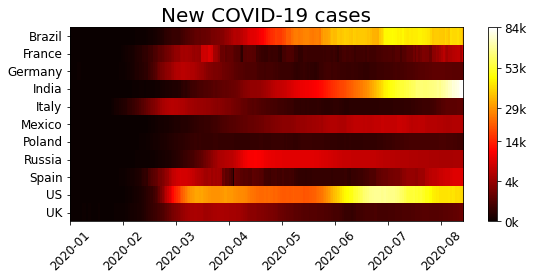

In [92]:
countries = ['Germany', 
             'France', 
             'Italy', 
             'Spain', 
             'United Kingdom', 
             'Russia', 
             'India', 
             'Brazil',
             'US', 
             'Poland', 
             'Mexico']

width = 1600
height = width / 2
dpi = 200
period = 7
step = 30
label_size = 12
n_clabels = 6

countries = sorted(countries)

plot_df = conf_diff[countries]
plot_df = plot_df.rename(columns={'United Kingdom': 'UK'})
countries = plot_df.columns.to_list()
plot_df = plot_df.rolling(period)
plot_df = plot_df.mean()
plot_df = plot_df.dropna()
plot_df = plot_df.to_numpy()
plot_df = plot_df.astype(float)
plot_df = plot_df.transpose()
plot_df = np.sqrt(plot_df)

xticks = range(plot_df.shape[1])[::step]
xlabels = list(conf_diff['Date'])[period:]
xlabels = [x.strftime(format='%Y-%m') for x in xlabels]
# xlabels = [x.date() for x in xlabels]
xlabels = xlabels[::step]

yticks = range(len(countries))
ylabels = countries

cticks = np.round(np.linspace(0, np.max(plot_df), 6), -1)
cticks = cticks.astype(np.int)
clabels = np.power(cticks, 2)
cticks = sorted(set(cticks))
clabels = np.power(cticks, 2)
clabels = [int((round(x, -3))/1000) for x in clabels]
clabels = [str(x)+'k' for x in clabels]
# clabels = list(map(str, clabels))

plt.figure(figsize=(width / dpi, height / dpi))
plt.imshow(plot_df, aspect='auto', interpolation='nearest')
plt.set_cmap('hot')

plt.yticks(ticks=yticks,
           labels=ylabels, 
           fontsize=label_size, 
           verticalalignment='center')

plt.xticks(ticks=xticks,
           labels=xlabels,
           rotation=45, 
           fontsize=label_size, 
           horizontalalignment='center')

cbar = plt.colorbar()
cbar.set_ticks(cticks)
cbar.set_ticklabels(clabels)
cbar.ax.tick_params(labelsize=label_size) 

plt.title('New COVID-19 cases', fontsize=20)

plt.tight_layout()
plt.savefig('img/covid_tiles.png')

plt.show()